In [1]:
# General imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
import time
import json

import warnings
warnings.filterwarnings('ignore')

# Pytorch imports
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Custom imports
from utils.plot import plot_results_hist, plot_training_results, plot_test_episodes, plot_n_training, compare_training_hp
from agents.dqn import Qnet, DQNAgent
from agents.random import randAgent
from utils.utils import play_episode, play_n_episodes

In [2]:
print(f'Installed GYM version is: {gym.__version__}')

Installed GYM version is: 0.26.2


In [3]:
# Set Seaborn aesthetics
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titlelocation'] = 'left'
plt.style.use('ggplot')

# Environment

In [4]:
env = gym.make("LunarLander-v2", render_mode='rgb_array')
print(f'Reward threshold is: {env.spec.reward_threshold}')
print(f'Reward range is: {env.reward_range}')
print(f'Maximun number of steps per episode: {env.spec.max_episode_steps}')
print(f'Action space dimension is: {env.action_space.n}')
print(f'Observation space dimension is: {env.observation_space.shape}')

Reward threshold is: 200
Reward range is: (-inf, inf)
Maximun number of steps per episode: 1000
Action space dimension is: 4
Observation space dimension is: (8,)


Las 4 acciones disponibles son:
* 0: No hacer nada
* 1: Encender el motor izquierdo
* 2: Encender el motor principal (bajo la nave)
* 3: Encender el motor derecho

Vemos que el estado es un vector de 8 elementos, que son, segun la [documentación de OpenAI](https://www.gymlibrary.dev/environments/box2d/lunar_lander/):
1. Posición en x
2. Posición en y
3. Velocidad en x
4. Velocidad en y
5. Ángulo
6. Velocidad angular
7. Booleano que indica si la pata izquierda está en contacto con el suelo
8. Booleano que indica si la pata derecha está en contacto con el suelo

In [5]:
random_agent = randAgent(env)
total_reward, steps = play_episode(env, random_agent, save=True)
print(f'Total reward: {total_reward}, Steps: {steps}')

Total reward: -213.00483424337665, Steps: 112


Resultado de la ejecución de un episodio con agente aleatorio:

![Agente aleatorio](videos/lunar_lander_randAgent.gif)

  0%|          | 0/1000 [00:00<?, ?it/s]

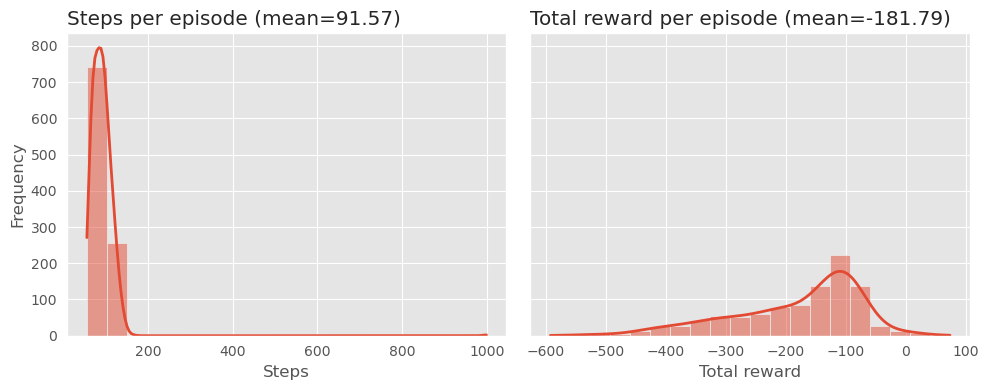

In [6]:
n_episodes = 1000
total_rewards, n_steps = play_n_episodes(env, random_agent, n_episodes)
# Plotting the results
plot_results_hist(n_steps, total_rewards)

# DQN Agent

In [5]:
############################
## SET DEFAULT PARAMETERS ##
############################

# Parameters that we are not going to change
MAX_EPISODES = 1000   # Maximun number of episodes
MIN_EPISODES = 250    # Minimun number of episodes
EPSILON_START = 1     # Initial value of epsilon
EPSILON_DECAY = .995  # Decay rate of epsilon
EPSILON_END = 0.01    # Final value of epsilon
BURN_IN = 1000        # Number of steps to fill the buffer

# Parameters that can be changed (hyperparameters)
GAMMA = 0.99          # Gamma parameter for the Bellman equation
BATCH_SIZE = 32       # Batch size
LR = 0.001           # Learning rate for the optimizer
MEMORY_SIZE = 8000    # Maximum size of the replay buffer
DNN_UPD = 4           # Frequency of updating the main network
DNN_SYNC = 100        # Frequency of synchronizing the target network
N_NEURONS = 64       # Number of neurons in the hidden layers

# Parameters to change agent's topology (DQN, Double DQN, Dueling DQN, NoisyNet DQN or any combination of them)
NOISY_NET = False      # Use noisy network
DUELING = False         # Use dueling network
DOUBLE = False         # Use double network

In [7]:
env = gym.make('LunarLander-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Qnet(n_inputs=env.observation_space.shape[0], n_hidden=N_NEURONS, 
             n_outputs=env.action_space.n).to(device)
obs = env.reset()[0]
obs_tensor = torch.Tensor(obs).to(device).unsqueeze(0)
print(f'Input tensor to the NN: {obs_tensor.shape}')
output = net(obs_tensor)
print(f'Output tensor:{output}')
print(f'Output tensor shape:{output.shape}')

Input tensor to the NN: torch.Size([1, 8])
Output tensor:tensor([[ 0.1292, -0.0257, -0.1394, -0.0923]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Output tensor shape:torch.Size([1, 4])


In [8]:
print('Network architecture:')
summary(net, input_size=(1,net.n_inputs))

Network architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             576
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 4]             260
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [6]:
def train_n(params, n_iter):
    env = gym.make("LunarLander-v2", render_mode='rgb_array')
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')
    n_training_res = []
    for i in range(n_iter):
        agent = DQNAgent(env, device=device, n_hidden=params['N_NEURONS'], mem_size=params['MEMORY_SIZE'],
                         gamma=params['GAMMA'], lr=params['LR'], noisyNet=params['NOISY_NET'], 
                         dueling=params['DUELING'], double=params['DOUBLE'])

        # Train agent
        res = agent.train(max_episodes=MAX_EPISODES, 
                                    min_episodios=MIN_EPISODES, 
                                    batch_size=params['BATCH_SIZE'], 
                                    eps_start=EPSILON_START, 
                                    eps_end=EPSILON_END,
                                    eps_decay=EPSILON_DECAY,
                                    dnn_update_frequency=params['DNN_UPD'], 
                                    dnn_sync_frequency=params['DNN_SYNC'])
        n_training_res.append(res)
        del agent
        torch.cuda.empty_cache()
    return n_training_res

In [11]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_init_res = train_n(dqn_hyperparams, 1)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 455 Mean Rewards 200.01 Epsilon 0.10		Environment solved in 455 episodes!


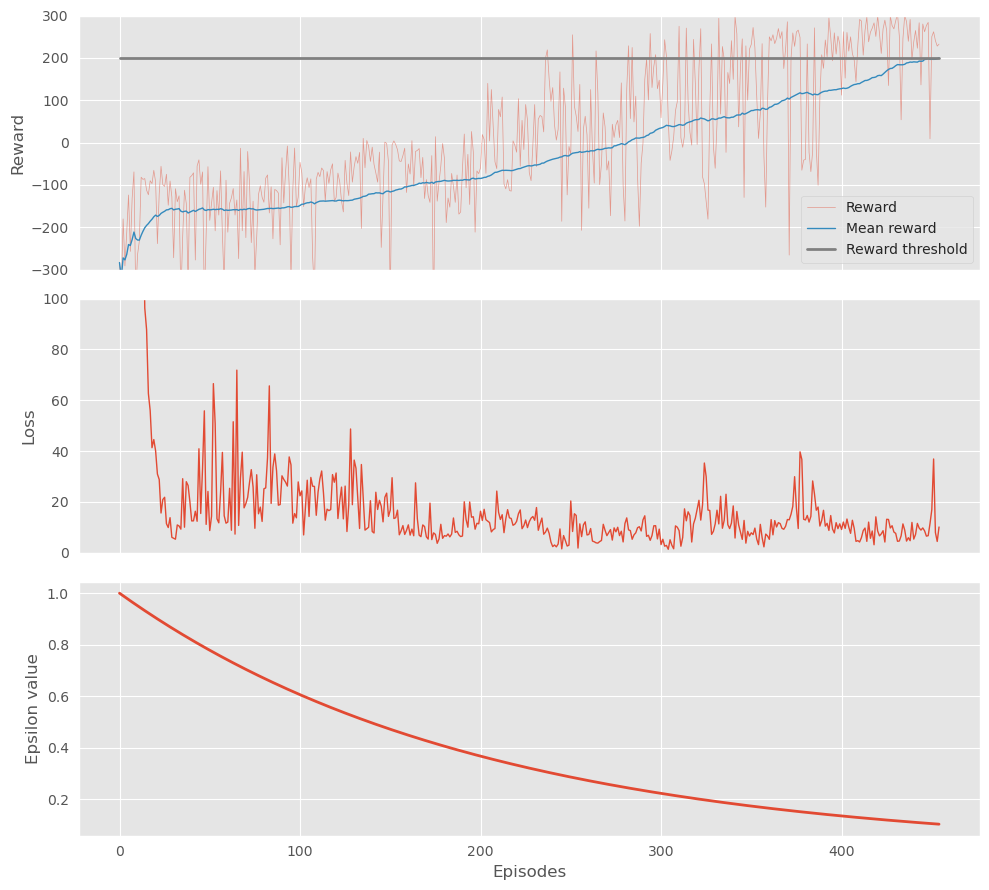

In [13]:
plot_training_results(dqn_init_res[0], 200)

## Hyperparameter tuning

In [7]:
def tune_hyperparameter(default_params, param_name, values, n_iter):
    result = {}
    params = default_params.copy()
    for value in values:
        params[param_name] = value
        res = train_n(params, n_iter)
        result[value] = res
    return result

In [16]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

tune_params = {
    'LR': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'BATCH_SIZE': [32, 64, 128],
    'N_NEURONS': [32, 64, 128],
    'DNN_UPD': [2, 4, 8],
    'DNN_SYNC': [100, 500, 1000],
    'MEMORY_SIZE': [4000, 8000, 16000, 32000],
    'GAMMA': [0.97, 0.99, 0.999]
    }

res_dqn_hp = {}

for param_name, param_values in tune_params.items():
    res_dqn_hp[param_name] = tune_hyperparameter(dqn_hyperparams, param_name, param_values, 5)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -383.52 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -357.38 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -348.67 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -377.55 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -223.60 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -181.88 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -120.04 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -303.13 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -189.75 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -113.99 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 565 Mean Rewards 201.50 Epsilon 0.06		Environment solved in 565 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 855 Mean Rewards 200.34 Epsilon 0.01		Environment solved in 855 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 758 Mean Rewards 201.28 Epsilon 0.02		Environment solved in 758 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 615 Mean Rewards 203.53 Epsilon 0.05		Environment solved in 615 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 126.75 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -48.32 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -5.04 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 127.67 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 768 Mean Rewards 200.83 Epsilon 0.02		Environment solved in 768 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 655 Mean Rewards 203.65 Epsilon 0.04		Environment solved in 655 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -78.08 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -109.88 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -83.40 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -60.92 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -58.81 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 201.22 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 656 Mean Rewards 200.95 Epsilon 0.04		Environment solved in 656 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 648 Mean Rewards 202.70 Epsilon 0.04		Environment solved in 648 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 501 Mean Rewards 202.47 Epsilon 0.08		Environment solved in 501 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 535 Mean Rewards 200.31 Epsilon 0.07		Environment solved in 535 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 536 Mean Rewards 200.68 Epsilon 0.07		Environment solved in 536 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 39.98 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 526 Mean Rewards 200.78 Epsilon 0.07		Environment solved in 526 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 566 Mean Rewards 202.56 Epsilon 0.06		Environment solved in 566 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 577 Mean Rewards 200.66 Epsilon 0.06		Environment solved in 577 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 69.81 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 551 Mean Rewards 200.13 Epsilon 0.06		Environment solved in 551 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 545 Mean Rewards 201.23 Epsilon 0.07		Environment solved in 545 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 836 Mean Rewards 200.47 Epsilon 0.02		Environment solved in 836 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 647 Mean Rewards 202.34 Epsilon 0.04		Environment solved in 647 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 599 Mean Rewards 200.63 Epsilon 0.05		Environment solved in 599 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -28.62 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 797 Mean Rewards 201.70 Epsilon 0.02		Environment solved in 797 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 168.77 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -51.80 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 617 Mean Rewards 200.09 Epsilon 0.05		Environment solved in 617 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 691 Mean Rewards 201.73 Epsilon 0.03		Environment solved in 691 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 72.84 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 885 Mean Rewards 202.66 Epsilon 0.01		Environment solved in 885 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 599 Mean Rewards 201.97 Epsilon 0.05		Environment solved in 599 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 496 Mean Rewards 202.76 Epsilon 0.08		Environment solved in 496 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 602 Mean Rewards 201.67 Epsilon 0.05		Environment solved in 602 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 541 Mean Rewards 203.41 Epsilon 0.07		Environment solved in 541 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 573 Mean Rewards 202.54 Epsilon 0.06		Environment solved in 573 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 478 Mean Rewards 200.88 Epsilon 0.09		Environment solved in 478 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 511 Mean Rewards 200.31 Epsilon 0.08		Environment solved in 511 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 633 Mean Rewards 200.02 Epsilon 0.04		Environment solved in 633 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 481 Mean Rewards 203.77 Epsilon 0.09		Environment solved in 481 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 614 Mean Rewards 200.04 Epsilon 0.05		Environment solved in 614 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 482 Mean Rewards 201.10 Epsilon 0.09		Environment solved in 482 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 696 Mean Rewards 200.55 Epsilon 0.03		Environment solved in 696 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 589 Mean Rewards 200.13 Epsilon 0.05		Environment solved in 589 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -75.65 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 607 Mean Rewards 200.20 Epsilon 0.05		Environment solved in 607 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 568 Mean Rewards 200.34 Epsilon 0.06		Environment solved in 568 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 175.13 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 2.44 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 792 Mean Rewards 203.43 Epsilon 0.02		Environment solved in 792 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -95.37 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -66.51 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 655 Mean Rewards 201.05 Epsilon 0.04		Environment solved in 655 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 565 Mean Rewards 200.76 Epsilon 0.06		Environment solved in 565 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 615 Mean Rewards 201.34 Epsilon 0.05		Environment solved in 615 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 168.65 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 578 Mean Rewards 202.79 Epsilon 0.06		Environment solved in 578 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 649 Mean Rewards 200.14 Epsilon 0.04		Environment solved in 649 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 515 Mean Rewards 200.58 Epsilon 0.08		Environment solved in 515 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 791 Mean Rewards 200.03 Epsilon 0.02		Environment solved in 791 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 666 Mean Rewards 200.51 Epsilon 0.04		Environment solved in 666 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 598 Mean Rewards 200.86 Epsilon 0.05		Environment solved in 598 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 638 Mean Rewards 201.65 Epsilon 0.04		Environment solved in 638 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 752 Mean Rewards 201.11 Epsilon 0.02		Environment solved in 752 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 881 Mean Rewards 200.50 Epsilon 0.01		Environment solved in 881 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 939 Mean Rewards 202.95 Epsilon 0.01		Environment solved in 939 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 602 Mean Rewards 200.01 Epsilon 0.05		Environment solved in 602 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 718 Mean Rewards 200.93 Epsilon 0.03		Environment solved in 718 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 713 Mean Rewards 200.23 Epsilon 0.03		Environment solved in 713 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 60.49 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 697 Mean Rewards 200.59 Epsilon 0.03		Environment solved in 697 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 728 Mean Rewards 201.91 Epsilon 0.03		Environment solved in 728 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 474 Mean Rewards 201.99 Epsilon 0.09		Environment solved in 474 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 619 Mean Rewards 200.09 Epsilon 0.05		Environment solved in 619 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 534 Mean Rewards 201.15 Epsilon 0.07		Environment solved in 534 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 646 Mean Rewards 201.28 Epsilon 0.04		Environment solved in 646 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 607 Mean Rewards 204.23 Epsilon 0.05		Environment solved in 607 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -78.70 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 492 Mean Rewards 200.72 Epsilon 0.09		Environment solved in 492 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 75.81 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 745 Mean Rewards 201.76 Epsilon 0.02		Environment solved in 745 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 962 Mean Rewards 201.29 Epsilon 0.01		Environment solved in 962 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 481 Mean Rewards 200.84 Epsilon 0.09		Environment solved in 481 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 624 Mean Rewards 200.01 Epsilon 0.04		Environment solved in 624 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 714 Mean Rewards 200.54 Epsilon 0.03		Environment solved in 714 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 511 Mean Rewards 203.12 Epsilon 0.08		Environment solved in 511 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 769 Mean Rewards 200.77 Epsilon 0.02		Environment solved in 769 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -45.60 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -46.40 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 103.14 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -13.92 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -50.93 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 626 Mean Rewards 200.24 Epsilon 0.04		Environment solved in 626 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 759 Mean Rewards 200.14 Epsilon 0.02		Environment solved in 759 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 680 Mean Rewards 201.65 Epsilon 0.03		Environment solved in 680 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 683 Mean Rewards 200.72 Epsilon 0.03		Environment solved in 683 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 970 Mean Rewards 200.68 Epsilon 0.01		Environment solved in 970 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -136.31 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -172.34 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -92.49 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -536.27 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -728.34 Epsilon 0.01		Episode limit reached.


Save tuning results

In [17]:
def json_default(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError('Not serializable')

with open(Path('training_stats')/'dqn_hyperparams.json', 'w') as f:
    json.dump(res_dqn_hp, f, default=json_default)

Load and print results

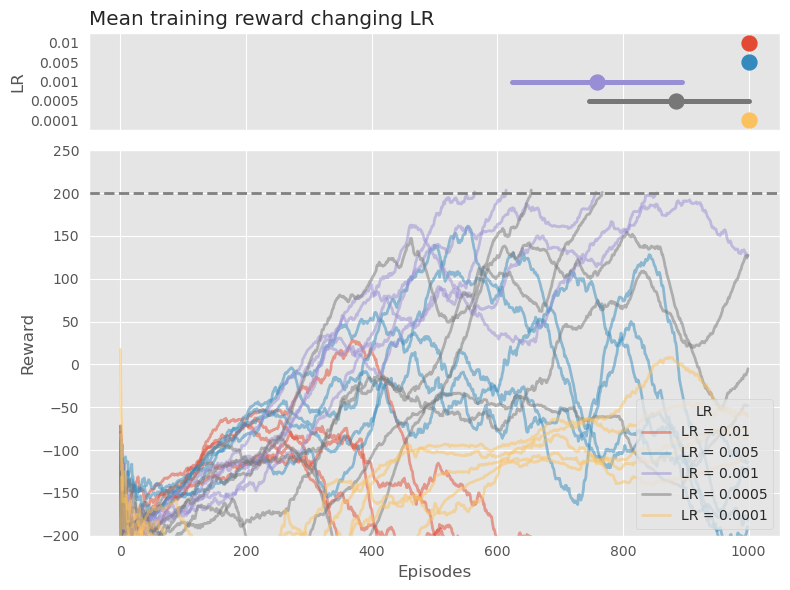

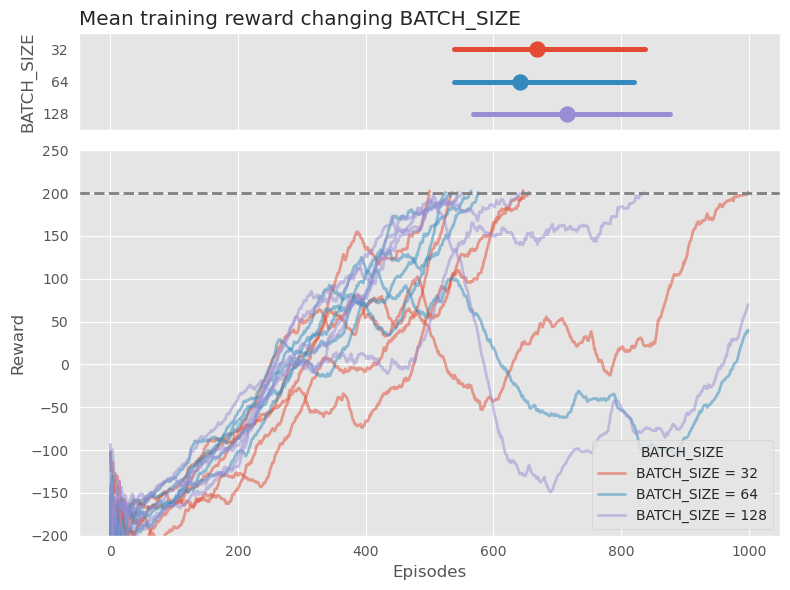

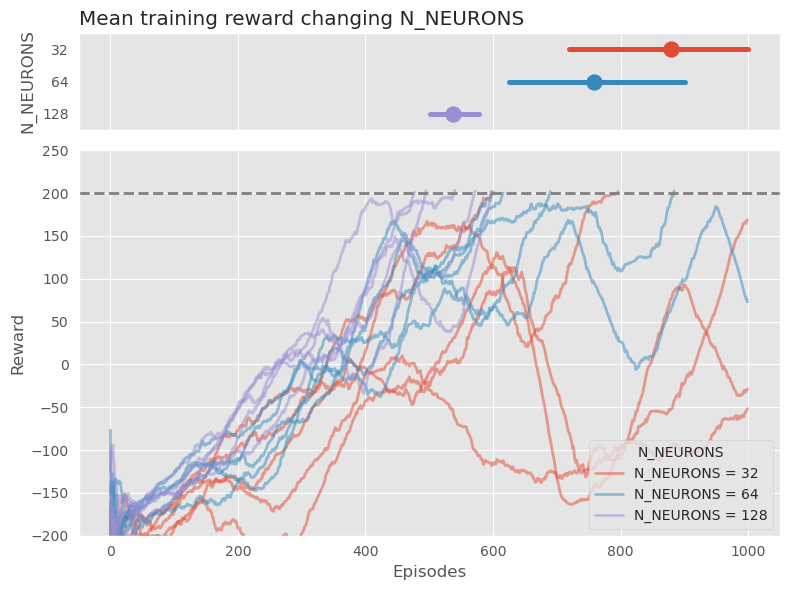

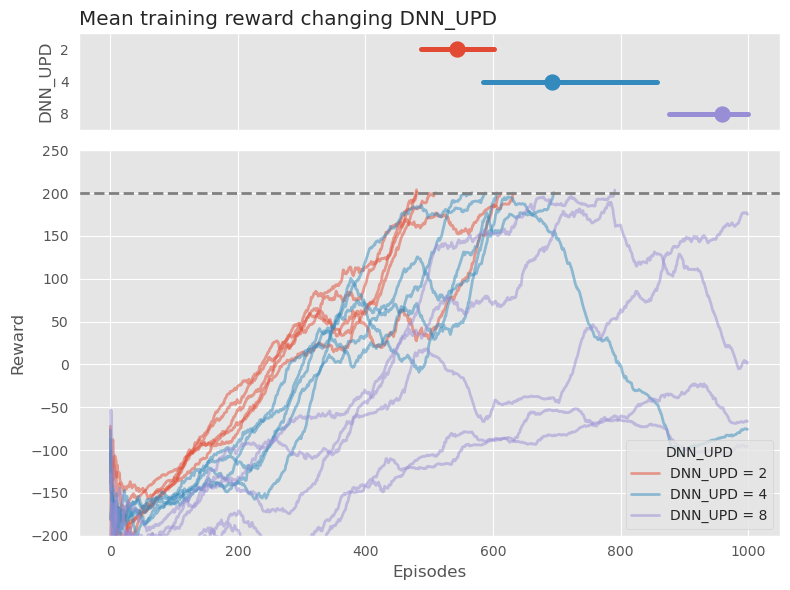

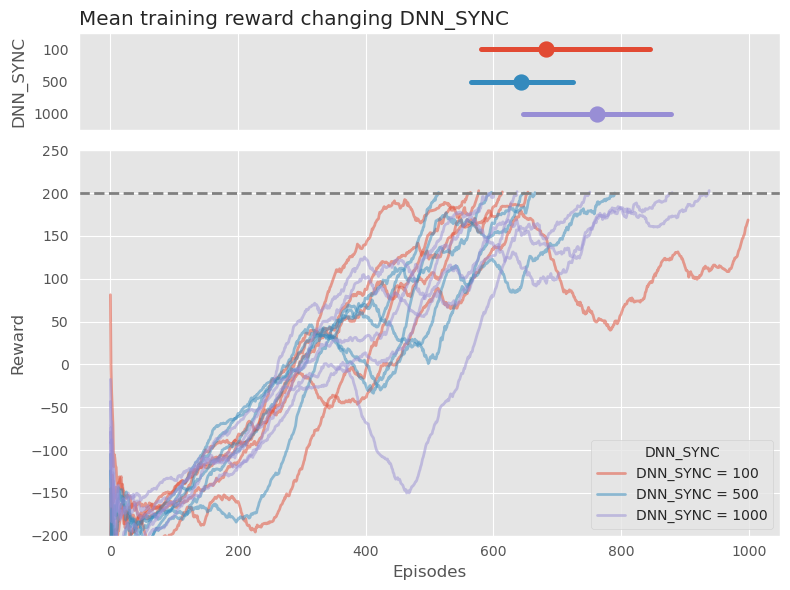

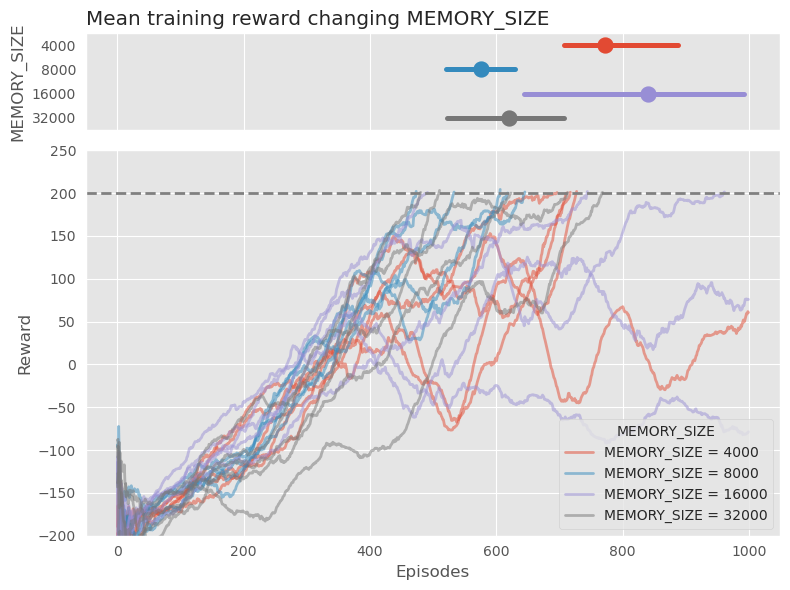

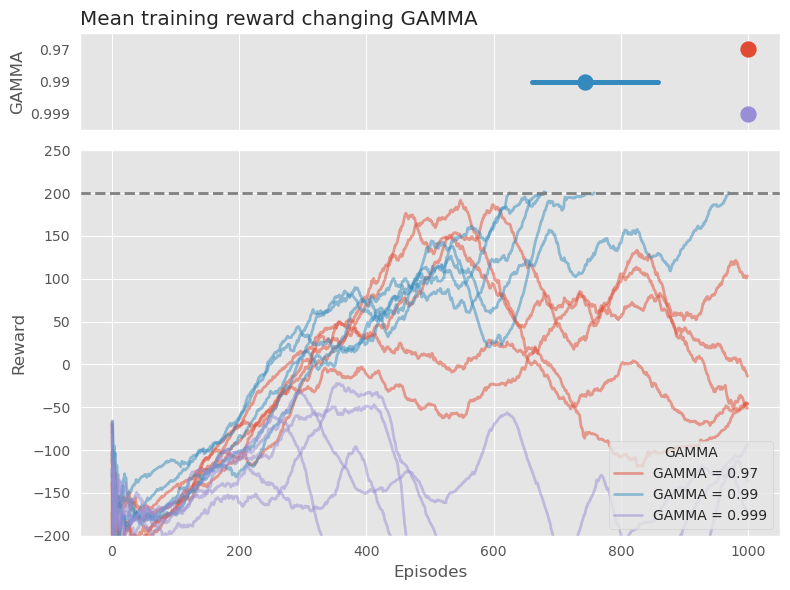

In [4]:
with open(Path('training_stats')/'dqn_hyperparams.json') as f:
    dqn_hyper = json.loads(f.read())
    
for param_name in dqn_hyper.keys():
    fig=compare_training_hp(dqn_hyper[param_name], 200, param_name)
    fig.savefig(Path('img')/f'dqn_param_{param_name}.png', dpi=300)

### Agente DQN optimo

In [26]:
# Parameters that can be changed (hyperparameters)
GAMMA = 0.99          # Gamma parameter for the Bellman equation
BATCH_SIZE = 64       # Batch size
LR = 0.001           # Learning rate for the optimizer
MEMORY_SIZE = 8000    # Maximum size of the replay buffer
DNN_UPD = 2           # Frequency of updating the main network
DNN_SYNC = 500        # Frequency of synchronizing the target network
N_NEURONS = 128       # Number of neurons in the hidden layers

# Parameters to change agent's topology (DQN, Double DQN, Dueling DQN, NoisyNet DQN or any combination of them)
NOISY_NET = False      # Use noisy network
DUELING = False         # Use dueling network
DOUBLE = False         # Use double network

In [9]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 622 Mean Rewards 200.22 Epsilon 0.04		Environment solved in 622 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 457 Mean Rewards 200.13 Epsilon 0.10		Environment solved in 457 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 439 Mean Rewards 203.29 Epsilon 0.11		Environment solved in 439 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 716 Mean Rewards 200.09 Epsilon 0.03		Environment solved in 716 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 611 Mean Rewards 202.52 Epsilon 0.05		Environment solved in 611 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 569 Mean Rewards 200.85 Epsilon 0.06		Environment solved in 569 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 500 Mean Rewards 201.58 Epsilon 0.08		Environment solved in 500 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 525 Mean Rewards 201.37 Epsilon 0.07		Environment solved in 525 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 595 Mean Rewards 203.61 Epsilon 0.05		Environment solved in 595 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 686 Mean Rewards 200.76 Epsilon 0.03		Environment solved in 686 episodes!


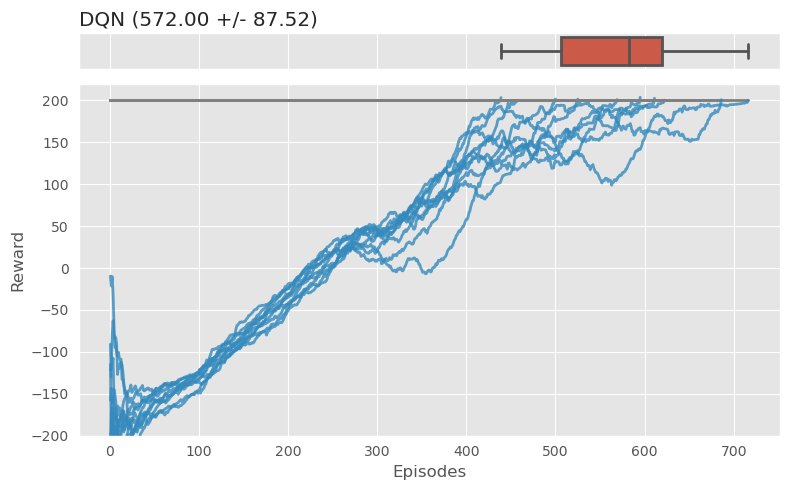

In [10]:
fig = plot_n_training(dqn_res, 200, 'DQN')
fig.savefig(Path('img')/f'dqn_opt_n_train.png', dpi=300)

## Test de agente entrenado

Entrenamiento con el mejor set de parámetros:

In [28]:
params = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

env = gym.make("LunarLander-v2", render_mode='rgb_array')

DQNagent = DQNAgent(env, device='cpu', n_hidden=params['N_NEURONS'], mem_size=params['MEMORY_SIZE'],
                    gamma=params['GAMMA'], lr=params['LR'], noisyNet=params['NOISY_NET'], 
                    dueling=params['DUELING'], double=params['DOUBLE'])

# Train agent
dqn_opt_res = DQNagent.train(max_episodes=MAX_EPISODES, 
                            min_episodios=MIN_EPISODES, 
                            batch_size=params['BATCH_SIZE'], 
                            eps_start=EPSILON_START, 
                            eps_end=EPSILON_END,
                            eps_decay=EPSILON_DECAY,
                            dnn_update_frequency=params['DNN_UPD'], 
                            dnn_sync_frequency=params['DNN_SYNC'])

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 693 Mean Rewards 201.53 Epsilon 0.03		Environment solved in 693 episodes!


Jugar un episodio y guardar video

In [30]:
total_reward_dqn, steps_dqn = play_episode(env, DQNagent, save=True)
print(f'Total reward: {total_reward_dqn}, Steps: {steps_dqn}')

Total reward: 247.55224297338785, Steps: 410


Resultado de la ejecución de un episodio con el agente DQN:

![Agente aleatorio](videos/lunar_lander_DQNAgent.gif)

Jugar 1000 episodios

  0%|          | 0/1000 [00:00<?, ?it/s]

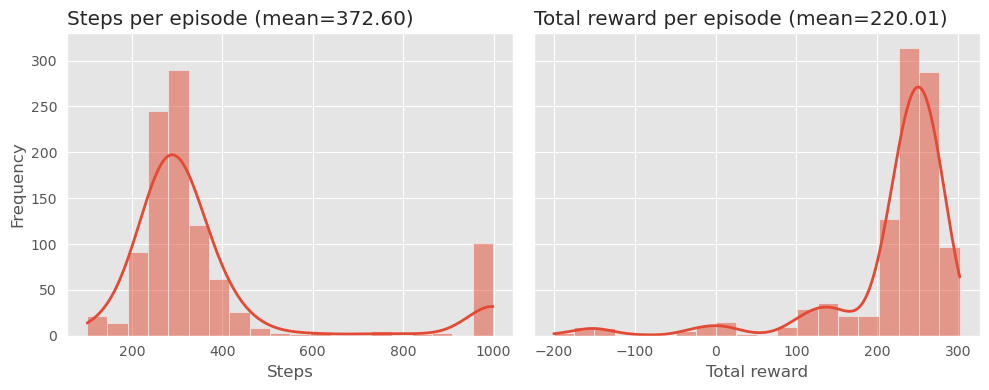

In [29]:
n_episodes = 1000
total_rewards_dqn, n_steps_dqn = play_n_episodes(env, DQNagent, n_episodes)
plot_results_hist(n_steps_dqn, total_rewards_dqn)

# Agente propuesto

### Double DQN

In [66]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_double_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 496 Mean Rewards 200.78 Epsilon 0.08		Environment solved in 496 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 607 Mean Rewards 201.79 Epsilon 0.05		Environment solved in 607 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 458 Mean Rewards 200.58 Epsilon 0.10		Environment solved in 458 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 796 Mean Rewards 201.00 Epsilon 0.02		Environment solved in 796 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 442 Mean Rewards 201.26 Epsilon 0.11		Environment solved in 442 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 609 Mean Rewards 201.68 Epsilon 0.05		Environment solved in 609 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 505 Mean Rewards 202.05 Epsilon 0.08		Environment solved in 505 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 469 Mean Rewards 200.31 Epsilon 0.10		Environment solved in 469 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 533 Mean Rewards 200.12 Epsilon 0.07		Environment solved in 533 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 434 Mean Rewards 200.58 Epsilon 0.11		Environment solved in 434 episodes!


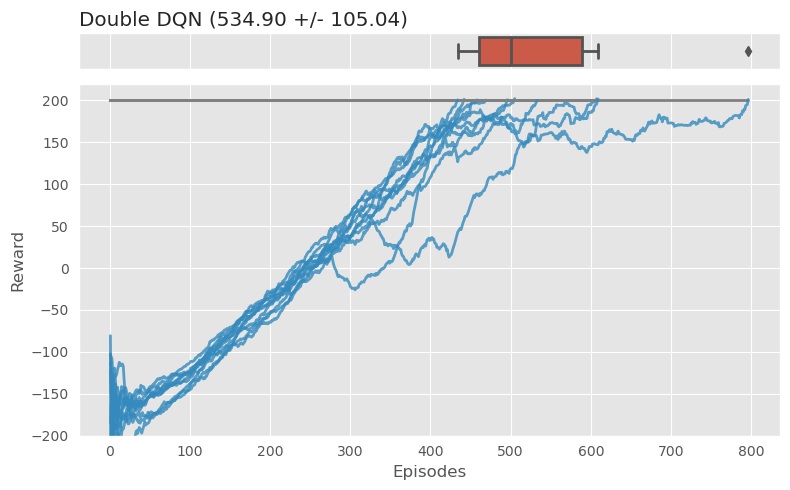

In [74]:
plot_n_training(dqn_double_res, 200, 'Double DQN')

In [68]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': 0.00025,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_double_res2 = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 483 Mean Rewards 201.69 Epsilon 0.09		Environment solved in 483 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 424 Mean Rewards 201.54 Epsilon 0.12		Environment solved in 424 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 427 Mean Rewards 200.89 Epsilon 0.12		Environment solved in 427 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 487 Mean Rewards 202.51 Epsilon 0.09		Environment solved in 487 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 502 Mean Rewards 200.14 Epsilon 0.08		Environment solved in 502 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 626 Mean Rewards 200.65 Epsilon 0.04		Environment solved in 626 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 453 Mean Rewards 201.84 Epsilon 0.10		Environment solved in 453 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 419 Mean Rewards 200.92 Epsilon 0.12		Environment solved in 419 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 620 Mean Rewards 200.10 Epsilon 0.04		Environment solved in 620 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 472 Mean Rewards 200.87 Epsilon 0.09		Environment solved in 472 episodes!


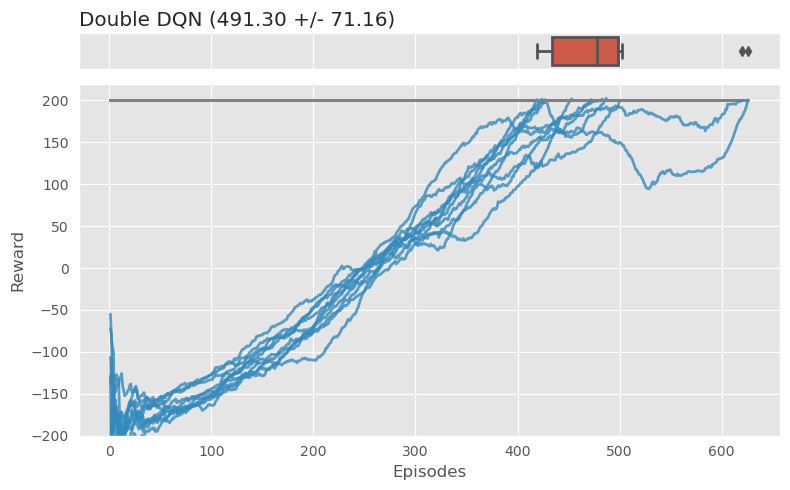

In [73]:
plot_n_training(dqn_double_res2, 200, 'Double DQN')

### Dueling DQN

In [62]:
dqn_hyperparams = {
    'DUELING': True,
    'NOISY_NET': False,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_dueling_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 488 Mean Rewards 202.44 Epsilon 0.09		Environment solved in 488 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 676 Mean Rewards 200.83 Epsilon 0.03		Environment solved in 676 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 564 Mean Rewards 204.38 Epsilon 0.06		Environment solved in 564 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 463 Mean Rewards 200.78 Epsilon 0.10		Environment solved in 463 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 428 Mean Rewards 201.14 Epsilon 0.12		Environment solved in 428 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 437 Mean Rewards 201.93 Epsilon 0.11		Environment solved in 437 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 524 Mean Rewards 200.38 Epsilon 0.07		Environment solved in 524 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 513 Mean Rewards 200.11 Epsilon 0.08		Environment solved in 513 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 460 Mean Rewards 202.73 Epsilon 0.10		Environment solved in 460 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 495 Mean Rewards 202.42 Epsilon 0.08		Environment solved in 495 episodes!


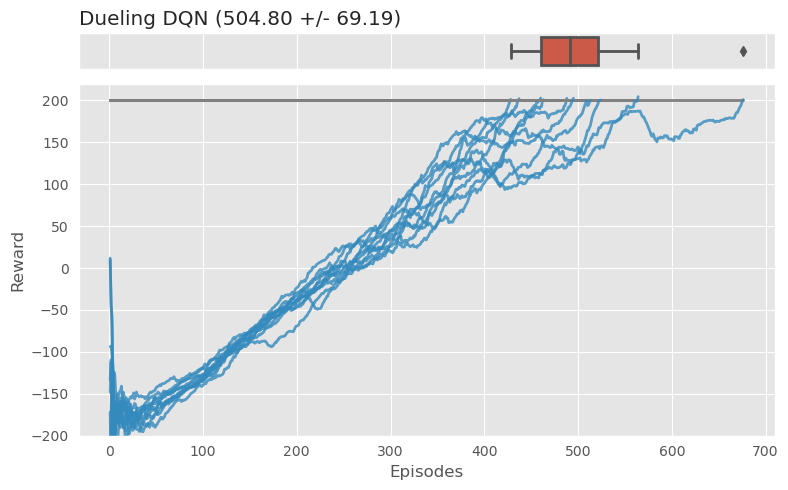

In [76]:
plot_n_training(dqn_dueling_res, 200, 'Dueling DQN')

### NoisyNET DQN

In [57]:
dqn_hyperparams = {
    'DUELING': False,
    'NOISY_NET': True,
    'DOUBLE': False,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_noisy_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 491 Mean Rewards 201.39 Epsilon 0.09		Environment solved in 491 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 495 Mean Rewards 201.46 Epsilon 0.08		Environment solved in 495 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 654 Mean Rewards 201.35 Epsilon 0.04		Environment solved in 654 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 532 Mean Rewards 202.30 Epsilon 0.07		Environment solved in 532 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 779 Mean Rewards 202.12 Epsilon 0.02		Environment solved in 779 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 443 Mean Rewards 200.90 Epsilon 0.11		Environment solved in 443 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 692 Mean Rewards 201.69 Epsilon 0.03		Environment solved in 692 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 670 Mean Rewards 201.11 Epsilon 0.03		Environment solved in 670 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 479 Mean Rewards 202.16 Epsilon 0.09		Environment solved in 479 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 379 Mean Rewards 200.76 Epsilon 0.15		Environment solved in 379 episodes!


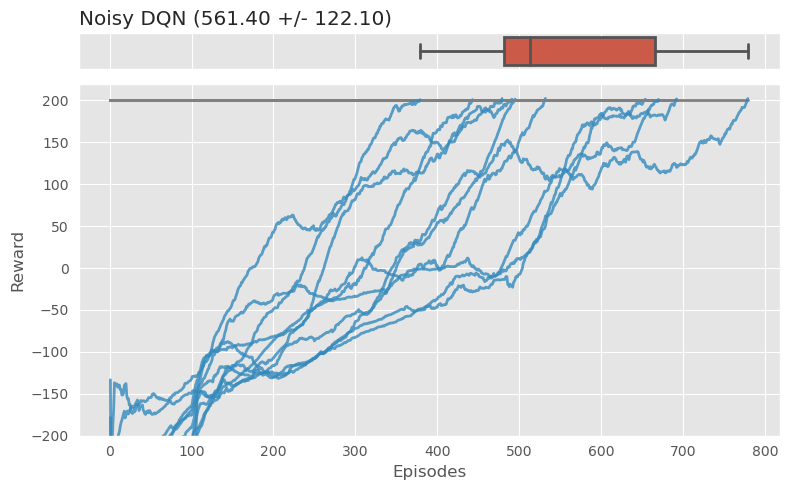

In [77]:
plot_n_training(dqn_noisy_res, 200, 'Noisy DQN')

### Double + Dueling DQN

In [155]:
dqn_hyperparams = {
    'DUELING': True,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_double_dueling_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 595 Mean Rewards 204.23 Epsilon 0.05		Environment solved in 595 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 510 Mean Rewards 200.17 Epsilon 0.08		Environment solved in 510 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 501 Mean Rewards 200.16 Epsilon 0.08		Environment solved in 501 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 632 Mean Rewards 200.40 Epsilon 0.04		Environment solved in 632 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 421 Mean Rewards 201.65 Epsilon 0.12		Environment solved in 421 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 405 Mean Rewards 200.01 Epsilon 0.13		Environment solved in 405 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 575 Mean Rewards 206.98 Epsilon 0.06		Environment solved in 575 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 491 Mean Rewards 200.07 Epsilon 0.09		Environment solved in 491 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 418 Mean Rewards 201.56 Epsilon 0.12		Environment solved in 418 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 727 Mean Rewards 200.63 Epsilon 0.03		Environment solved in 727 episodes!


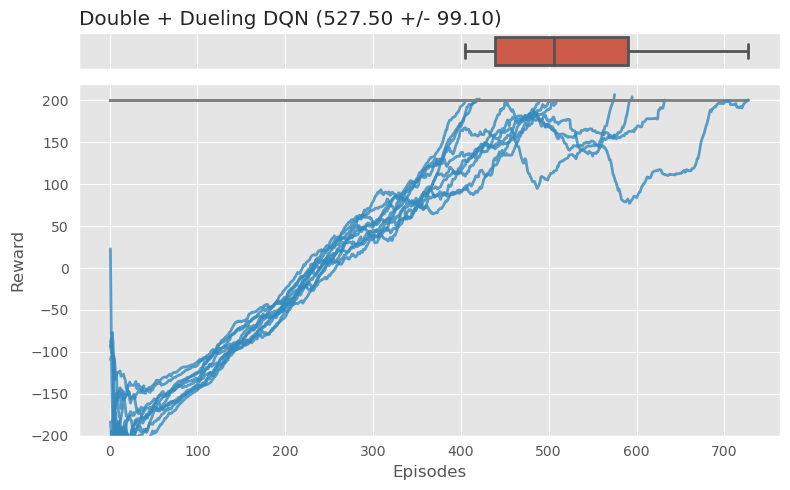

In [157]:
plot_n_training(dqn_double_dueling_res, 200, 'Double + Dueling DQN')

## Hyperparameters tuning (Double + Dueling DQN)

In [192]:
dqn_hyperparams = {
    'DUELING': True,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

tune_params = {
    'LR': [0.001, 0.0005, 0.00025, 0.0001],
    'BATCH_SIZE': [32, 64, 128],
    'N_NEURONS': [32, 64, 128],
    'DNN_UPD': [1, 2, 4, 8],
    'MEMORY_SIZE': [4000, 8000, 16000, 32000],
    'GAMMA': [0.98, 0.99, 0.995]
    }

res = {}

for param_name, param_values in tune_params.items():
    res[param_name] = tune_hyperparameter(dqn_hyperparams, param_name, param_values, 5)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 733 Mean Rewards 201.94 Epsilon 0.03		Environment solved in 733 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 551 Mean Rewards 200.32 Epsilon 0.06		Environment solved in 551 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 577 Mean Rewards 200.71 Epsilon 0.06		Environment solved in 577 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 689 Mean Rewards 202.61 Epsilon 0.03		Environment solved in 689 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 681 Mean Rewards 200.40 Epsilon 0.03		Environment solved in 681 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 480 Mean Rewards 201.01 Epsilon 0.09		Environment solved in 480 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 449 Mean Rewards 200.62 Epsilon 0.11		Environment solved in 449 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 439 Mean Rewards 200.67 Epsilon 0.11		Environment solved in 439 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 464 Mean Rewards 200.08 Epsilon 0.10		Environment solved in 464 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 493 Mean Rewards 200.28 Epsilon 0.08		Environment solved in 493 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 506 Mean Rewards 201.43 Epsilon 0.08		Environment solved in 506 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 525 Mean Rewards 201.74 Epsilon 0.07		Environment solved in 525 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 475 Mean Rewards 201.23 Epsilon 0.09		Environment solved in 475 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 459 Mean Rewards 200.22 Epsilon 0.10		Environment solved in 459 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 499 Mean Rewards 205.57 Epsilon 0.08		Environment solved in 499 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 483 Mean Rewards 200.90 Epsilon 0.09		Environment solved in 483 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 812 Mean Rewards 201.51 Epsilon 0.02		Environment solved in 812 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 497 Mean Rewards 202.30 Epsilon 0.08		Environment solved in 497 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 769 Mean Rewards 200.29 Epsilon 0.02		Environment solved in 769 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 926 Mean Rewards 200.60 Epsilon 0.01		Environment solved in 926 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 481 Mean Rewards 200.67 Epsilon 0.09		Environment solved in 481 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 445 Mean Rewards 200.47 Epsilon 0.11		Environment solved in 445 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 512 Mean Rewards 200.65 Epsilon 0.08		Environment solved in 512 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 488 Mean Rewards 202.69 Epsilon 0.09		Environment solved in 488 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 499 Mean Rewards 200.92 Epsilon 0.08		Environment solved in 499 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 501 Mean Rewards 200.20 Epsilon 0.08		Environment solved in 501 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 474 Mean Rewards 201.31 Epsilon 0.09		Environment solved in 474 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 444 Mean Rewards 200.79 Epsilon 0.11		Environment solved in 444 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 424 Mean Rewards 200.33 Epsilon 0.12		Environment solved in 424 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 441 Mean Rewards 200.23 Epsilon 0.11		Environment solved in 441 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 555 Mean Rewards 201.25 Epsilon 0.06		Environment solved in 555 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 394 Mean Rewards 200.20 Epsilon 0.14		Environment solved in 394 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 434 Mean Rewards 200.35 Epsilon 0.11		Environment solved in 434 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 600 Mean Rewards 203.32 Epsilon 0.05		Environment solved in 600 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 515 Mean Rewards 203.25 Epsilon 0.08		Environment solved in 515 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 59.07 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -29.88 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -94.15 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 448 Mean Rewards 200.46 Epsilon 0.11		Environment solved in 448 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -91.66 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 562 Mean Rewards 201.46 Epsilon 0.06		Environment solved in 562 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 551 Mean Rewards 202.71 Epsilon 0.06		Environment solved in 551 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 4.95 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 556 Mean Rewards 201.65 Epsilon 0.06		Environment solved in 556 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 545 Mean Rewards 200.03 Epsilon 0.07		Environment solved in 545 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 496 Mean Rewards 200.19 Epsilon 0.08		Environment solved in 496 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 494 Mean Rewards 203.41 Epsilon 0.08		Environment solved in 494 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 584 Mean Rewards 201.52 Epsilon 0.05		Environment solved in 584 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 408 Mean Rewards 201.36 Epsilon 0.13		Environment solved in 408 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 440 Mean Rewards 200.16 Epsilon 0.11		Environment solved in 440 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 854 Mean Rewards 201.28 Epsilon 0.01		Environment solved in 854 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -34.24 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 506 Mean Rewards 202.42 Epsilon 0.08		Environment solved in 506 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 549 Mean Rewards 201.08 Epsilon 0.06		Environment solved in 549 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 651 Mean Rewards 202.44 Epsilon 0.04		Environment solved in 651 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 554 Mean Rewards 201.62 Epsilon 0.06		Environment solved in 554 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 512 Mean Rewards 200.91 Epsilon 0.08		Environment solved in 512 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 481 Mean Rewards 200.19 Epsilon 0.09		Environment solved in 481 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 421 Mean Rewards 201.06 Epsilon 0.12		Environment solved in 421 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 406 Mean Rewards 200.42 Epsilon 0.13		Environment solved in 406 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 415 Mean Rewards 201.33 Epsilon 0.13		Environment solved in 415 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 429 Mean Rewards 200.99 Epsilon 0.12		Environment solved in 429 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 470 Mean Rewards 200.38 Epsilon 0.10		Environment solved in 470 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 515 Mean Rewards 203.54 Epsilon 0.08		Environment solved in 515 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 450 Mean Rewards 200.02 Epsilon 0.11		Environment solved in 450 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 846 Mean Rewards 200.91 Epsilon 0.01		Environment solved in 846 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 650 Mean Rewards 200.90 Epsilon 0.04		Environment solved in 650 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 589 Mean Rewards 201.63 Epsilon 0.05		Environment solved in 589 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 918 Mean Rewards 200.30 Epsilon 0.01		Environment solved in 918 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 864 Mean Rewards 201.38 Epsilon 0.01		Environment solved in 864 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 473 Mean Rewards 200.07 Epsilon 0.09		Environment solved in 473 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 529 Mean Rewards 201.38 Epsilon 0.07		Environment solved in 529 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 594 Mean Rewards 201.97 Epsilon 0.05		Environment solved in 594 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 431 Mean Rewards 200.35 Epsilon 0.12		Environment solved in 431 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 455 Mean Rewards 200.50 Epsilon 0.10		Environment solved in 455 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 436 Mean Rewards 200.71 Epsilon 0.11		Environment solved in 436 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 482 Mean Rewards 200.88 Epsilon 0.09		Environment solved in 482 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 522 Mean Rewards 200.01 Epsilon 0.07		Environment solved in 522 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 507 Mean Rewards 202.38 Epsilon 0.08		Environment solved in 507 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 459 Mean Rewards 201.82 Epsilon 0.10		Environment solved in 459 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 494 Mean Rewards 201.29 Epsilon 0.08		Environment solved in 494 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 564 Mean Rewards 200.61 Epsilon 0.06		Environment solved in 564 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 407 Mean Rewards 200.13 Epsilon 0.13		Environment solved in 407 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 432 Mean Rewards 200.75 Epsilon 0.12		Environment solved in 432 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 420 Mean Rewards 201.39 Epsilon 0.12		Environment solved in 420 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 417 Mean Rewards 200.02 Epsilon 0.12		Environment solved in 417 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 365 Mean Rewards 200.73 Epsilon 0.16		Environment solved in 365 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 403 Mean Rewards 202.24 Epsilon 0.13		Environment solved in 403 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 390 Mean Rewards 200.32 Epsilon 0.14		Environment solved in 390 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 433 Mean Rewards 200.41 Epsilon 0.11		Environment solved in 433 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 468 Mean Rewards 200.02 Epsilon 0.10		Environment solved in 468 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 529 Mean Rewards 200.39 Epsilon 0.07		Environment solved in 529 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 460 Mean Rewards 200.43 Epsilon 0.10		Environment solved in 460 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 823 Mean Rewards 200.01 Epsilon 0.02		Environment solved in 823 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 400 Mean Rewards 200.49 Epsilon 0.14		Environment solved in 400 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 449 Mean Rewards 203.38 Epsilon 0.11		Environment solved in 449 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 488 Mean Rewards 206.08 Epsilon 0.09		Environment solved in 488 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 486 Mean Rewards 203.06 Epsilon 0.09		Environment solved in 486 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 450 Mean Rewards 203.68 Epsilon 0.11		Environment solved in 450 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 612 Mean Rewards 201.99 Epsilon 0.05		Environment solved in 612 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 462 Mean Rewards 200.16 Epsilon 0.10		Environment solved in 462 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 511 Mean Rewards 205.26 Epsilon 0.08		Environment solved in 511 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards -25.74 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 1000 Mean Rewards 20.40 Epsilon 0.01		Episode limit reached.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 452 Mean Rewards 201.21 Epsilon 0.10		Environment solved in 452 episodes!


Save training stats

In [259]:
def json_default(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError('Not serializable')

with open(Path('training_stats')/'dqn_double_dueling_hyperparams.json', 'w') as f:
    json.dump(res, f, default=json_default)

Plot results

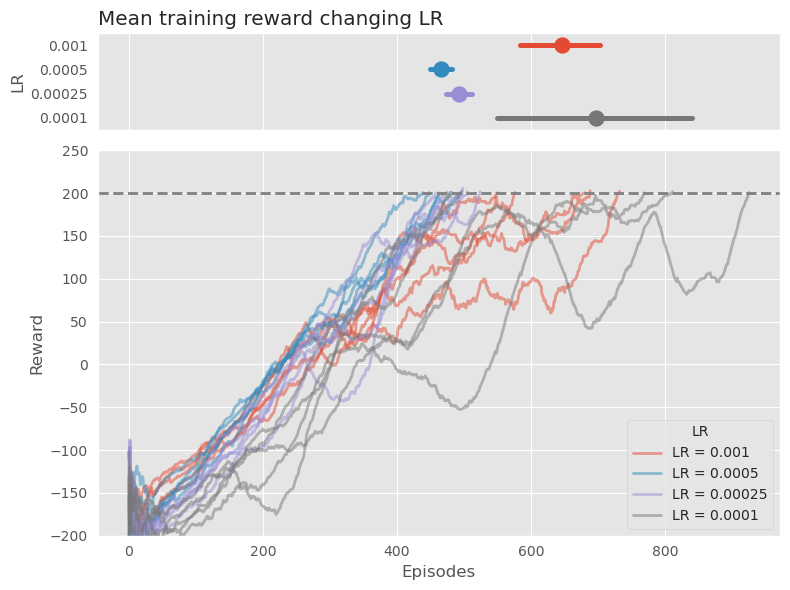

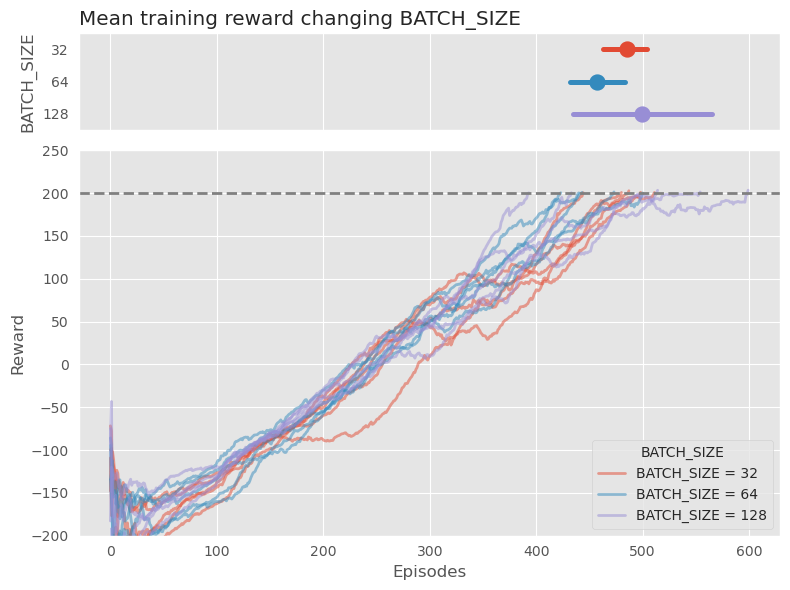

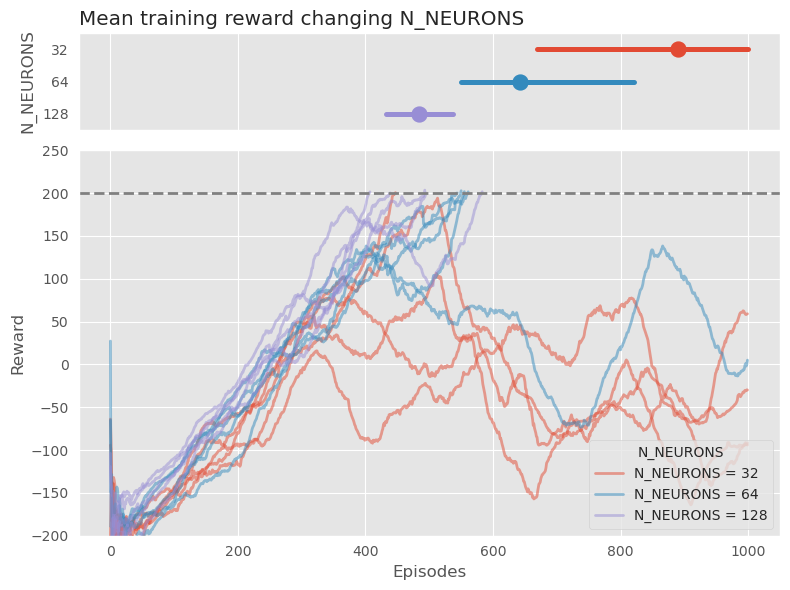

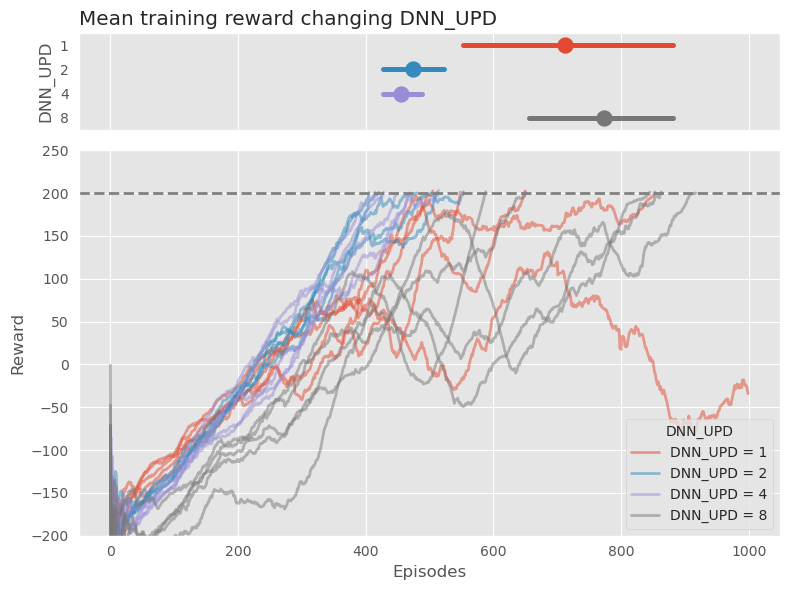

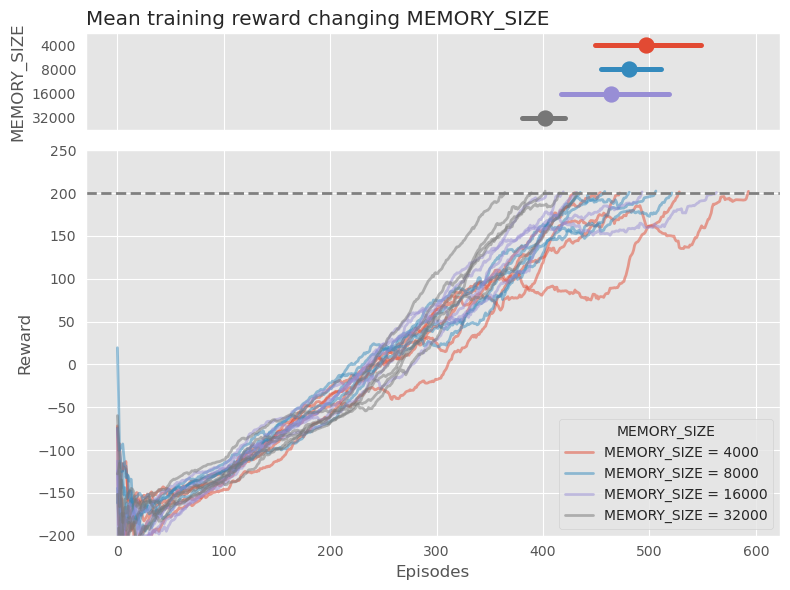

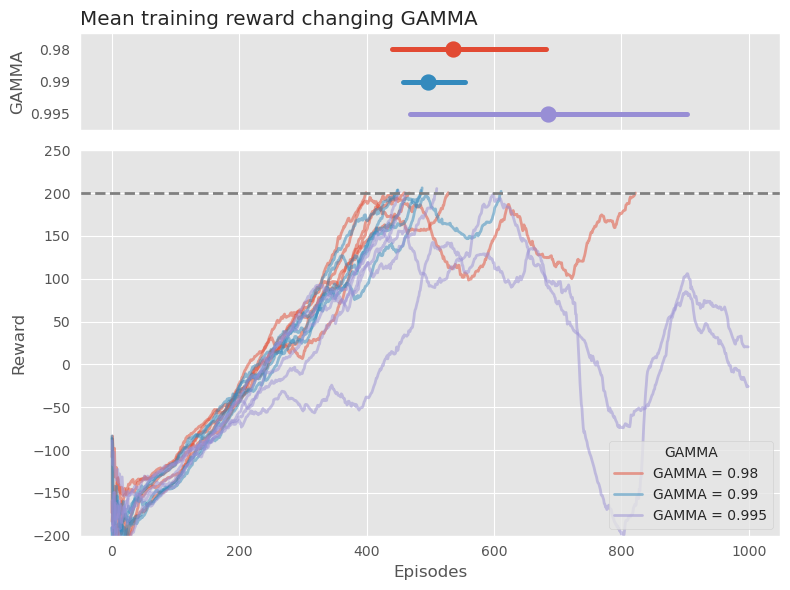

In [258]:
with open(Path('training_stats')/'dqn_double_dueling_hyperparams2.json') as f:
    dqn_double_dueling_hyper = json.loads(f.read())
    
for param_name in dqn_double_dueling_hyper.keys():
    fig=compare_training_hp(dqn_double_dueling_hyper[param_name], 200, param_name)
    fig.savefig(Path('img')/f'dqn_double_dueling_param_{param_name}.png', dpi=300)

### Optimun Double Dueling DQN

In [14]:
# Parameters that can be changed (hyperparameters)
GAMMA = 0.99          # Gamma parameter for the Bellman equation
BATCH_SIZE = 64       # Batch size
LR = 0.0005           # Learning rate for the optimizer
MEMORY_SIZE = 32000    # Maximum size of the replay buffer
DNN_UPD = 4           # Frequency of updating the main network
DNN_SYNC = 500        # Frequency of synchronizing the target network
N_NEURONS = 128       # Number of neurons in the hidden layers

In [12]:
dqn_hyperparams = {
    'DUELING': True,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

dqn_res = train_n(dqn_hyperparams, 10)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 392 Mean Rewards 200.60 Epsilon 0.14		Environment solved in 392 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 548 Mean Rewards 200.90 Epsilon 0.06		Environment solved in 548 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 490 Mean Rewards 211.93 Epsilon 0.09		Environment solved in 490 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 434 Mean Rewards 200.24 Epsilon 0.11		Environment solved in 434 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 466 Mean Rewards 201.07 Epsilon 0.10		Environment solved in 466 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 535 Mean Rewards 200.53 Epsilon 0.07		Environment solved in 535 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 427 Mean Rewards 200.39 Epsilon 0.12		Environment solved in 427 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 428 Mean Rewards 200.00 Epsilon 0.12		Environment solved in 428 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 495 Mean Rewards 202.02 Epsilon 0.08		Environment solved in 495 episodes!


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 419 Mean Rewards 200.19 Epsilon 0.12		Environment solved in 419 episodes!


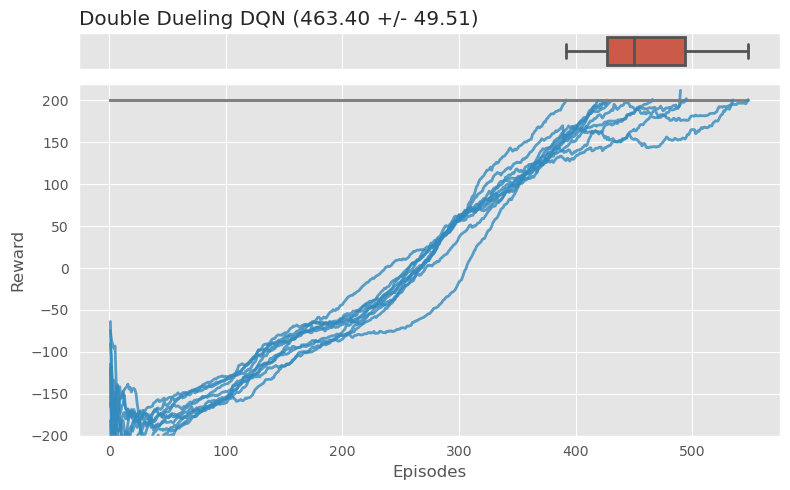

In [13]:
fig = plot_n_training(dqn_res, 200, 'Double Dueling DQN')
fig.savefig(Path('img')/f'dqn_double_dueling_opt_n_train.png', dpi=300)

### Prueba agente Double Dueling DQN

Entrenamiento con el mejor set de parámetros:

In [22]:
params = {
    'DUELING': True,
    'NOISY_NET': False,
    'DOUBLE': True,
    'N_NEURONS': N_NEURONS,
    'BATCH_SIZE': BATCH_SIZE,
    'GAMMA': GAMMA,
    'LR': LR,
    'MEMORY_SIZE': MEMORY_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'DNN_SYNC': DNN_SYNC,
    'DNN_UPD': DNN_UPD,
}

env = gym.make("LunarLander-v2", render_mode='rgb_array')

DDDQNagent = DQNAgent(env, device='cpu', n_hidden=params['N_NEURONS'], mem_size=params['MEMORY_SIZE'],
                    gamma=params['GAMMA'], lr=params['LR'], noisyNet=params['NOISY_NET'], 
                    dueling=params['DUELING'], double=params['DOUBLE'])

# Train agent
dqn_double_dueling_opt_res = DDDQNagent.train(max_episodes=MAX_EPISODES, 
                            min_episodios=MIN_EPISODES, 
                            batch_size=params['BATCH_SIZE'], 
                            eps_start=EPSILON_START, 
                            eps_end=EPSILON_END,
                            eps_decay=EPSILON_DECAY,
                            dnn_update_frequency=params['DNN_UPD'], 
                            dnn_sync_frequency=params['DNN_SYNC'])

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 521 Mean Rewards 203.01 Epsilon 0.07		Environment solved in 521 episodes!


Jugar un episodio y guardar video

In [19]:
total_rewards_dddqn, n_steps_dddqn = play_episode(env, DDDQNagent, save=True)
print(f'Total reward: {total_rewards_dddqn}, Steps: {n_steps_dddqn}')

Total reward: 251.7797835442335, Steps: 325


Jugar 1000 episodios

In [23]:
n_episodes = 1000
total_rewards_dddqn, n_steps_dddqn = play_n_episodes(env, DDDQNagent, n_episodes)

  0%|          | 0/1000 [00:00<?, ?it/s]

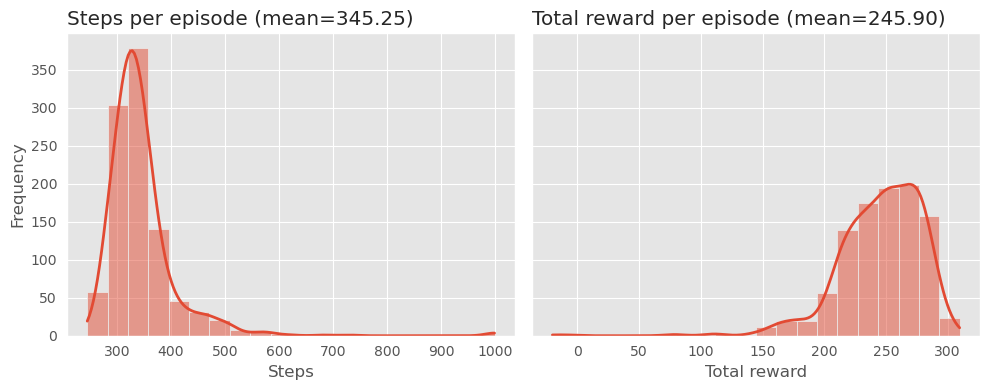

In [24]:
plot_results_hist(n_steps_dddqn, total_rewards_dddqn)

In [32]:
test_trained_agent_cmp= pd.DataFrame({'DQN':total_rewards_dqn, 'DDDQN':total_rewards_dddqn}).melt()

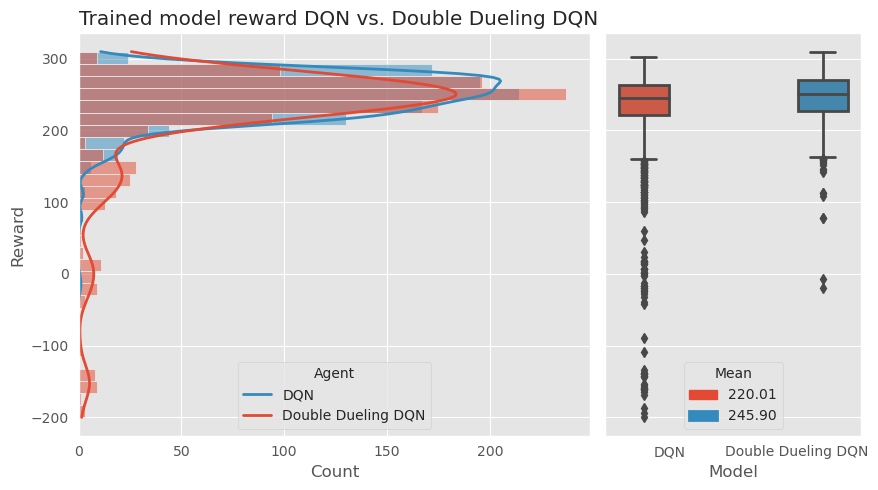

In [103]:
fig, ax = plt.subplots(1,2,figsize=(9,5), gridspec_kw={'width_ratios':[2,1]}, sharey=True)
sns.histplot(data=test_trained_agent_cmp, y='value', hue='variable', bins=30, kde=True, ax=ax[0])
ax[0].legend(['DQN', 'Double Dueling DQN'], title='Agent', loc='lower center')
ax[0].set_title('Trained model reward DQN vs. Double Dueling DQN')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Reward')

# Boxplot
sns.boxplot(x='variable', y='value', hue='variable', data=test_trained_agent_cmp, ax=ax[1])
means = test_trained_agent_cmp.groupby(['variable'])['value'].mean()
ax[1].legend([f'{means["DQN"]:.2f}', f'{means["DDDQN"]:.2f}'], 
             loc='lower center', title='Mean')
leg = ax[1].get_legend()
colors = [color['color'] for color in list(plt.rcParams['axes.prop_cycle'])[:2]]
for i in range(2):
    leg.legendHandles[i].set_color(colors[i])
ax[1].set_xticklabels(['DQN', 'Double Dueling DQN'])
ax[1].set_xlabel('Model')
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()
fig.savefig(Path('img')/f'trained_agent_cmp.png', dpi=300)